$\textbf{Short Description:}$  
This Jupyter notebook primarily focuses on the implementation of Unet model and its application from scratch on the Image Segmentation problem. Training was performed using the CWFID dataset and they are visualized on the session of Load Data. However, due to computational constraints, the model was trained on a small size dataset and for a limited number of epochs. 

# Import Libraries

In [2]:
import numpy as np
np.random.seed(1)
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from PIL import Image
import math
import cv2

# Load Data
Dataset: CWFID segmentation dataset from the domain of agricultural robotics [1]

There are 40 training instances of size 224 x 224
There are 21 test instances of size 224 x 224


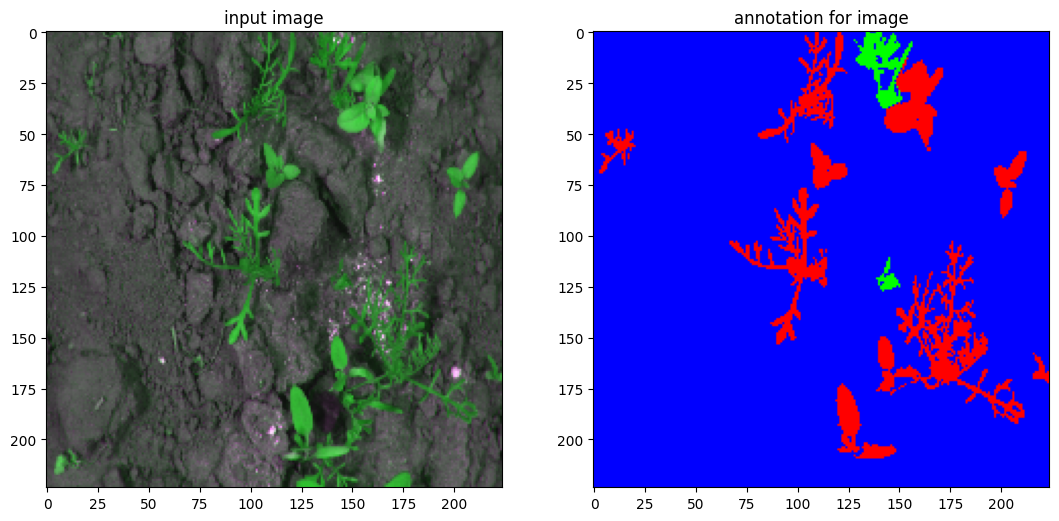

In [3]:
def load_segmentation_data(reduce_numSamples=None):
  data = np.load('segmentation_data.npz')
  if reduce_numSamples:
    train_x = data['train_x'][:reduce_numSamples,:,:,:]
    train_y = data['train_y'][:reduce_numSamples,:,:,:]
    test_x = data['test_x'][:int(reduce_numSamples*0.2),:,:,:]
    test_y = data['test_y'][:int(reduce_numSamples*0.2),:,:,:]
  else:
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
  return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = load_segmentation_data()
print('There are %i training instances of size %i x %i' % (train_x.shape[0],train_x.shape[1],train_x.shape[2]))
print('There are %i test instances of size %i x %i' % (test_x.shape[0],test_x.shape[1],test_x.shape[2]))
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title("input image")
plt.imshow(train_x[0,:,:,:])

plt.subplot(1,3,2)
plt.title("annotation for image")
plt.imshow(train_y[0,:,:,:])

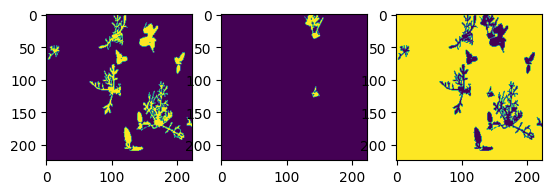

In [4]:
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(train_y[0,:,:,i])

# U-Net architecture

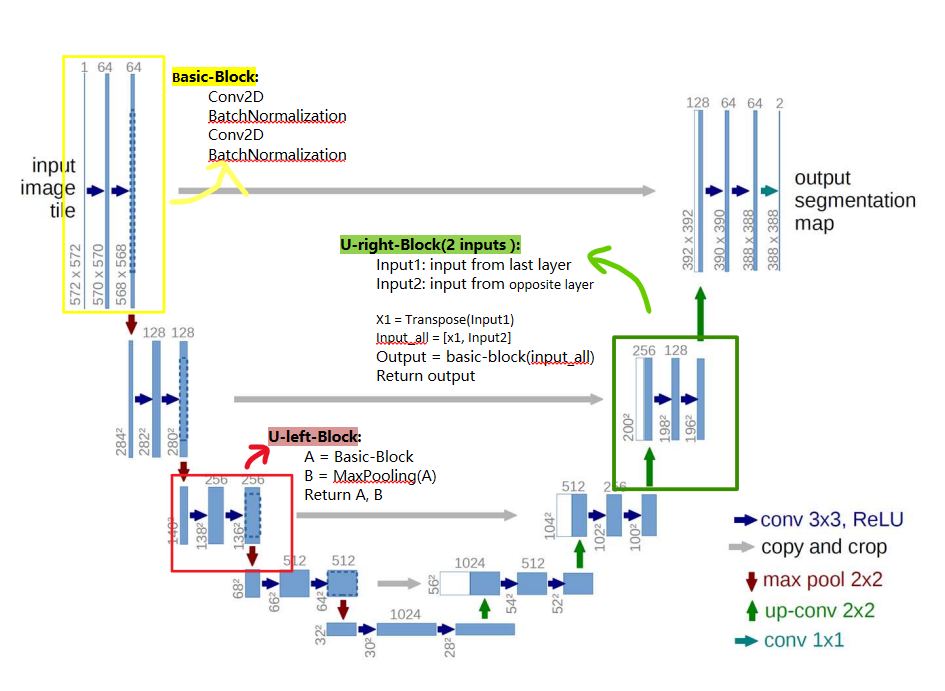


In [5]:
def basic_block(input, num_filter):
  x = keras.layers.Conv2D(num_filter, 3, padding='same')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(num_filter, 3, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)

  return x


def U_left_Bock(input, num_filter):
  x = basic_block(input, num_filter)
  x_maxPool = keras.layers.MaxPool2D((2,2))(x)

  return x, x_maxPool

def U_right_Block(input, add_input, num_filter):
  x_upConv = keras.layers.Conv2DTranspose(num_filter, 2, strides=2, padding='same')(input)
  x_concatenate = keras.layers.Concatenate()([x_upConv, add_input])

  # x_concatenate = x_upConv
  x = basic_block(x_concatenate, num_filter)

  return x


def U_Net(input_shape):
  inputs = keras.Input(input_shape) # shape=(, 3)

  L1, L1_maxPool = U_left_Bock(inputs, 64)
  L2, L2_maxPool = U_left_Bock(L1_maxPool, 128)
  L3, L3_maxPool = U_left_Bock(L2_maxPool, 256)
  L4, L4_maxPool = U_left_Bock(L3_maxPool, 512)

  # buttom, just conv block and without pooling
  L5 = basic_block(L4_maxPool, 1024)

  L6 = U_right_Block(L5, L4, 512)
  L7 = U_right_Block(L6, L3, 256)
  L8 = U_right_Block(L7, L2, 128)
  L9 = U_right_Block(L8, L1, 64)

  # output segmentation map
  outputs = keras.layers.Conv1D(1, 1, padding='same', activation='sigmoid')(L9)

  model = keras.Model(inputs, outputs)
  return model


img_width = train_x.shape[1]
img_height = train_x.shape[2]
img_channels = train_x.shape[3]
input_shape = (img_width, img_height, img_channels)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train and Evaluate
Because of the limitation of computational sources of my personal laptop, the model was trained only limited number of epochs. But while it was trained for roughly 500 epochs, it had well performances on the prediction (on the visualization session)

In [13]:
running_epochs = 20 
# 500

In [6]:
model_0 = U_Net(input_shape)
model_0.compile(optimizer="Adam", loss='binary_crossentropy', metrics="accuracy")
model_0.fit(train_x, train_y[:,:,:,0], epochs=running_epochs)
model_0.evaluate(test_x, test_y[:,:,:,0])  # Returns the loss value & metrics values

Epoch 1/20
2/2 [==============================] - 51s 9s/step - loss: 0.9177 - accuracy: 0.5223
Epoch 2/20
2/2 [==============================] - 50s 10s/step - loss: 0.7946 - accuracy: 0.7134
Epoch 3/20
2/2 [==============================] - 56s 11s/step - loss: 0.6218 - accuracy: 0.7614
Epoch 4/20
2/2 [==============================] - 73s 14s/step - loss: 0.5787 - accuracy: 0.8272
Epoch 5/20
2/2 [==============================] - 71s 13s/step - loss: 0.5602 - accuracy: 0.8869
Epoch 6/20
2/2 [==============================] - 66s 14s/step - loss: 0.5487 - accuracy: 0.8991
Epoch 7/20
2/2 [==============================] - 66s 14s/step - loss: 0.5404 - accuracy: 0.9025
Epoch 8/20
2/2 [==============================] - 64s 13s/step - loss: 0.5335 - accuracy: 0.9106
Epoch 9/20
2/2 [==============================] - 74s 15s/step - loss: 0.5252 - accuracy: 0.9190
Epoch 10/20
2/2 [==============================] - 71s 16s/step - loss: 0.5172 - accuracy: 0.9202
Epoch 11/20
2/2 [=============

[2.89164662361145, 0.7649416923522949]

In [14]:
model_1 = U_Net(input_shape)
model_1.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics="accuracy")
model_1.fit(train_x, train_y[:,:,:,1], epochs=running_epochs)
model_1.evaluate(test_x, test_y[:,:,:,1])

Epoch 1/20
2/2 [==============================] - 73s 13s/step - loss: 0.9700 - accuracy: 0.5263
Epoch 2/20
2/2 [==============================] - 67s 13s/step - loss: 0.7748 - accuracy: 0.5028
Epoch 3/20
2/2 [==============================] - 64s 13s/step - loss: 0.7081 - accuracy: 0.6450
Epoch 4/20
2/2 [==============================] - 65s 13s/step - loss: 0.6908 - accuracy: 0.6049
Epoch 5/20
2/2 [==============================] - 60s 12s/step - loss: 0.6657 - accuracy: 0.6175
Epoch 6/20
2/2 [==============================] - 62s 13s/step - loss: 0.6535 - accuracy: 0.7711
Epoch 7/20
2/2 [==============================] - 65s 14s/step - loss: 0.6397 - accuracy: 0.8045
Epoch 8/20
2/2 [==============================] - 61s 12s/step - loss: 0.6331 - accuracy: 0.8411
Epoch 9/20
2/2 [==============================] - 63s 13s/step - loss: 0.6199 - accuracy: 0.8650
Epoch 10/20
2/2 [==============================] - 66s 13s/step - loss: 0.6136 - accuracy: 0.8562
Epoch 11/20
2/2 [============

[4.83546257019043, 0.5948005318641663]

In [18]:
model_2 = U_Net(input_shape)
model_2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics="accuracy")
model_2.fit(train_x, train_y[:,:,:,2], epochs=running_epochs)
model_2.evaluate(test_x, test_y[:,:,:,2])

Epoch 1/20
2/2 [==============================] - 86s 15s/step - loss: 0.9623 - accuracy: 0.4760
Epoch 2/20
2/2 [==============================] - 73s 13s/step - loss: 0.5952 - accuracy: 0.8017
Epoch 3/20
2/2 [==============================] - 63s 12s/step - loss: 0.4995 - accuracy: 0.8901
Epoch 4/20
2/2 [==============================] - 62s 13s/step - loss: 0.4683 - accuracy: 0.9011
Epoch 5/20
2/2 [==============================] - 60s 12s/step - loss: 0.4623 - accuracy: 0.8816
Epoch 6/20
2/2 [==============================] - 58s 12s/step - loss: 0.4386 - accuracy: 0.9143
Epoch 7/20
2/2 [==============================] - 63s 12s/step - loss: 0.4339 - accuracy: 0.9126
Epoch 8/20
2/2 [==============================] - 60s 12s/step - loss: 0.4248 - accuracy: 0.9163
Epoch 9/20
2/2 [==============================] - 62s 12s/step - loss: 0.4137 - accuracy: 0.9205
Epoch 10/20
2/2 [==============================] - 60s 13s/step - loss: 0.4075 - accuracy: 0.9199
Epoch 11/20
2/2 [============

[1.145782709121704, 0.9220004081726074]

# visualization of predictions

1/1 [==============================] - 8s 8s/step


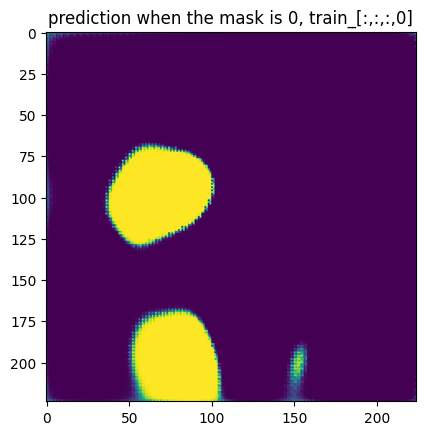

In [9]:
pred_0 = model_0.predict(test_x)
pred0_sample = pred_0[5]
plt.imshow(np.squeeze(pred0_sample))
plt.title("prediction when the mask is 0, train_[:,:,:,0]")
plt.show()

1/1 [==============================] - 5s 5s/step


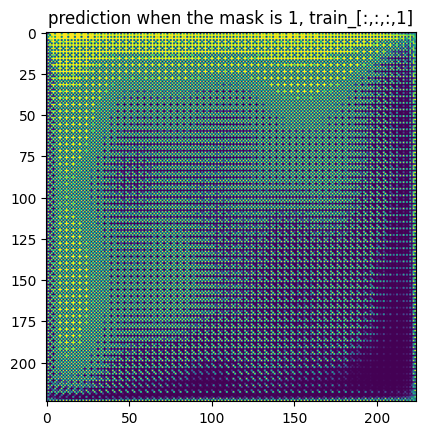

In [17]:
pred_1 = model_1.predict(test_x)
pred1_sample = pred_1[5]
plt.imshow(np.squeeze(pred1_sample))
plt.title("prediction when the mask is 1, train_[:,:,:,1]")
plt.show()

# Reference Papers
[1] S. Haug and J. Ostermann. A Crop/Weed Field Image Dataset for the Evaluation
of Computer Vision Based Precision Agriculture Tasks, 2015, Computer Vision - ECCV
2014 Workshops.
